In [5]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import re
import os
import glob
import sys

# Directory where all the experiments are found. 
# Must end with "/" at the end
dir = "/Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/"

#arch (used in function names for estimate of exec time)
zarch = "z17"

In [6]:
# Version with curve fitting models to a two variable function and --profile-ir approach
# data generated with script unit-new-meas/commands.sh

# graph: on the y axis it is seconds (because that is what make-report does by default.
# on the x axis for CPU: its the multiplication of each of the dims (for linear/non matmul). For matmul, its the matmul complexity
#    for NNPA, we do a regression and we take the proper ratio between the two metrics we use.

# For matrix multiply.
NNPA_N_CEIL  = 2.0
NNPA_N_CEIL2 = 32.0
NNPA_M_CEIL  = 64.0
NNPA_K_CEIL  = 64.0

# For elemntwise and others.
NNPA_E2_CEIL  = 2.0
NNPA_E2_CEIL2 = 32.0
NNPA_E1_CEIL  = 64.0

def ms_ceiling(n, m):
    return np.ceil(n/m) * m

def filter_complexity(df, dev_name, max_compute, min_mean, min_e1, min_e2):
    # cap of compute at val
    # cap of meas at 1.1us as the resolution of the timers is 1us.
    df_filter = df[(df["opCompute"] < max_compute) & (df["mean"] > min_mean) & (df["e1"]>=min_e1)  & (df["e2"]>=min_e2)] .copy()
    print(dev_name, ": original rows", df.shape[0], ", filtered rows", df_filter.shape[0])
    assert df_filter.shape[0]>0, "filtered too agressively, dev=" + dev_name + ", cap at=" + str(val) 
    return df_filter

def scan_csv(file_name):
    # Has no header, state so.
    df = pd.read_csv(file_name, header=None)
    # print(df.to_string())
    # Give names.
    df.columns =["titleTile", "e3", "e2", "e1", "titleOption", "option", "opName", "invokeNum", "measAverage", "mean", "percent"] 
    # Get rid of titles.
    df1 = df.drop(columns=["titleTile", "titleOption",  "opName",  "measAverage", "percent"])
    #print(df1.to_string())
    return df1

def prepare_cpu_data(df, op_name):
    # Get data for cpu, using "~" to indicate "all but the ones that...". . 
    df_cpu = df[~df["option"].str.contains("-maccel=NNPA")].copy()
    if re.match(r'MatMul', op_name):
        if re.match(r'MatMul2D', op_name):
            print("CPU: Use MatMul 2D compute complexity.")
            # MatMul2D test uses e1-3 in different ways: (N=e3 x M=e2) * (M=e2 x K=e1).
            (N, M, K) = ("e3", "e2", "e1")
            df_cpu["opCompute"] = (df_cpu[N] * df_cpu[M] * df_cpu[K])
        else:
            print("CPU: Use MatMul 3D compute complexity.")
            # MatMul test uses e1-3 in different ways: (B=e3 x N=e2 x M=e1) * (B=e3 x M=e1 x K=e1).
            # Namely the second matrix is square.
            (B, N, M, K) = ("e3", "e2", "e1", "e1")
            # Simply states broadcast B times N * M * K
            df_cpu["opCompute"] = df_cpu[B] * (df_cpu[N] * df_cpu[M] * df_cpu[K])
        code_cpu  = "(double B, double N, double M, double K) {\n"
        code_cpu += "  double complexity = B * (N * M * K);\n"
    else:
        df_cpu["opCompute"] = df_cpu["e3"] * df_cpu["e2"] * df_cpu["e1"]
        code_cpu  = "(double e3, double e2, double e1) {\n"
        code_cpu += "  double complexity = e3 * e2 * e1;\n"
    df_cpu["opTime"] = df_cpu["mean"]
    return (df_cpu, code_cpu)

def prepare_nnpa_data(df, op_name):
    # Get only the data for options with NNPA. 
    # Must add a copy to let Pandas know we want a whole new table, not a view.
    df_nnpa = df[df["option"].str.contains("-maccel=NNPA")].copy()
    if re.match(r'MatMul', op_name):
        if re.match(r'MatMul2D', op_name):
            print("NNPA: Use MatMul 2D compute complexity.")
            # MatMul test uses e1-3 in different ways: (N=e3 x M=e2) * (M=e2 x K=e1).
            (N, M, K) = ("e3", "e2", "e1")
            # not sure the formula below is correct.
            # Cedric's formula is ceil(N/2)*2 * ceil(M/64)*64 * ceil(K/64)*64. Works much better with ceil(N,32)*32.
            df_nnpa["opCompute"]  = ms_ceiling(df_nnpa[N], NNPA_N_CEIL)  * ms_ceiling(df_nnpa[M], NNPA_M_CEIL) * ms_ceiling(df_nnpa[K], NNPA_K_CEIL)
            df_nnpa["opCompute2"] = ms_ceiling(df_nnpa[N], NNPA_N_CEIL2) * ms_ceiling(df_nnpa[M], NNPA_M_CEIL) * ms_ceiling(df_nnpa[K], NNPA_K_CEIL)
        else:
            print("NNPA: Use MatMul 3D compute complexity.")
            # MatMul test uses e1-3 in different ways: (B=e3 x N=e2 x M=e1) * (B=e3 x M=e1 x K=e1).
            (B, N, M, K) = ("e3", "e2", "e1", "e1")
            # Cedric's formula is ceil(N/2)*2 * ceil(M/64)*64 * ceil(K/64)*64. Works much better with ceil(N,32)*32.
            # Simply states broadcast B times Cedric's formula
            df_nnpa["opCompute"]  = df_nnpa[B] * ms_ceiling(df_nnpa[N], NNPA_N_CEIL)  * ms_ceiling(df_nnpa[M], NNPA_M_CEIL) * ms_ceiling(df_nnpa[K], NNPA_K_CEIL)
            df_nnpa["opCompute2"] = df_nnpa[B] * ms_ceiling(df_nnpa[N], NNPA_N_CEIL2) * ms_ceiling(df_nnpa[M], NNPA_M_CEIL) * ms_ceiling(df_nnpa[K], NNPA_K_CEIL)
        code_nnpa =  "(double B, double N, double M, double K) {\n"
        code_nnpa += "  double complexity  = B * ms_ceiling(N, {:.1f}) * ms_ceiling(M, {:.1f}) * ms_ceiling(K, {:.1f});\n".format(NNPA_N_CEIL, NNPA_M_CEIL, NNPA_K_CEIL)
        code_nnpa += "  double complexity2 = B * ms_ceiling(N, {:.1f}) * ms_ceiling(M, {:.1f}) * ms_ceiling(K, {:.1f});\n".format(NNPA_N_CEIL2, NNPA_M_CEIL, NNPA_K_CEIL)
    else:
        df_nnpa["opCompute"]  = df_nnpa["e3"] * ms_ceiling(df_nnpa["e2"], NNPA_E2_CEIL)  * ms_ceiling(df_nnpa["e1"], NNPA_E1_CEIL)
        df_nnpa["opCompute2"] = df_nnpa["e3"] * ms_ceiling(df_nnpa["e2"], NNPA_E2_CEIL2) * ms_ceiling(df_nnpa["e1"], NNPA_E1_CEIL)
        code_nnpa  = "(double e3, double e2, double e1) {\n"
        code_nnpa += "  double complexity  = e3 * ms_ceiling(e2, {:.1f}) * ms_ceiling(e1, {:.1f});\n".format(NNPA_E2_CEIL, NNPA_E1_CEIL)
        code_nnpa += "  double complexity2 = e3 * ms_ceiling(e2, {:.1f}) * ms_ceiling(e1, {:.1f});\n".format(NNPA_E2_CEIL2, NNPA_E1_CEIL)
    df_nnpa["opTime"] = df_nnpa["mean"]
    return (df_nnpa, code_nnpa)

def compute_regr(df, dev_name, op_name, color_name, print_graph=0):
    # Extract vectors for CPU regression, reshaping them as regression expect them to be: [lenCpu, 1].
    if dev_name == "NNPA":
        # Create an x array with one row per data point, and 2 columns, one for each complexity metric.
        x = np.vstack((df.opCompute.values, df.opCompute2.values)).T
    else:
        # create an x array with one row per data point and one column for the single complexity metric
        x = df.opCompute.values.reshape(-1, 1)
    y = df.opTime.values.reshape(-1, 1)
    #print(x, y)
    # Compute CPU Regression. See https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    r2 = regr.score(x, y)
    # Compute a scatter friendly single dimension x for scatter analysis
    if dev_name == "NNPA":
        b = regr.coef_[0][0]
        c = regr.coef_[0][1]
        # 2D regression is f(x, y) = a + bx + cy
        # Now projecting (x, y) -> (z) where z = (bx + cy)/(b+c) 
        #   we get g(z) = a + (b + c)z  and by substituting z by its def above, we get
        #   g(z) = a + bx + cy 
        x_scatter = df.opCompute.values * b / (b+c) + df.opCompute2.values * c / (b+c)
    else:
        x_scatter = x

    print(dev_name, ": regression coef, ", regr.coef_, ", intercept", regr.intercept_, ", r2, ", r2)
    if print_graph >= 2:
        # Plot CPU regression
        plt.scatter(x_scatter, y,  color='black')
        plt.plot(x_scatter, regr.predict(x), color=color_name, linewidth=3)
        plt.title(op_name + " on " + dev_name + " with r2 " + str(r2))
        plt.show()
    if print_graph >= 3:
        df["opPredict"] = regr.predict(x)
        df["opErrorRatio"] = df["opPredict"] / df["opTime"]
        cutoff = 0.15
        df_predict_too_small = df[df["opErrorRatio"] < (1.0 - cutoff)].copy()
        predict_too_small_num = df_predict_too_small.shape[0]
        df_predict_too_big = df[df["opErrorRatio"] > (1.0 + cutoff)].copy()
        predict_too_big_num = df_predict_too_big.shape[0]
        print("Error for op", op_name, "and dev", dev_name);
        print("Measurement smaller than prediciton for", predict_too_big_num, "data points:\n")
        if predict_too_big_num > 0:
            print(df_predict_too_big.to_string(), "\n")
        print("Measurement larger than prediciton for", predict_too_small_num, "data points:\n")
        if predict_too_small_num > 0:
            print(df_predict_too_small.to_string(), "\n")
    return (regr, x, x_scatter, y, r2)

def print_cross_over_graph(op_name, regr_cpu, x_cpu, y_cpu, regr_nnpa, x_nnpa, x_scatter_nnpa, y_nnpa, print_graph):
    plt.plot(x_cpu, regr_cpu.predict(x_cpu), color='blue', linewidth=1, label="CPU")
    plt.plot(x_scatter_nnpa, regr_nnpa.predict(x_nnpa), color='red', linewidth=1, label="NNPA")
    if print_graph>=2:
        plt.scatter(x_cpu, y_cpu, color='blue')
        plt.scatter(x_scatter_nnpa, y_nnpa, color='red')
    plt.legend()
    plt.title(op_name)
    plt.show()

def gen_cpu_code(op_name, regr_cpu, code_cpu, r2_cpu):
    c_op_name = op_name.replace("-", "_")
    code = "// Operation " + c_op_name + ": estimated times.\n"
    code +=  "static double " + zarch + "_estimatedTimeForCPU_" + c_op_name + code_cpu 
    code += "  // Regression for CPU with r2 = " + str(r2_cpu) + "\n"
    code += "  return " + str(regr_cpu.intercept_[0]) + " + " + str(regr_cpu.coef_[0][0]) + " * complexity;\n"
    code += "}\n"
    return code;

def gen_nnpa_code(op_name, regr_nnpa, code_nnpa, r2_nnpa):
    c_op_name = op_name.replace("-", "_")
    code = "// Operation " + c_op_name + ": estimated times.\n"
    code +=  "static double " + zarch + "_estimatedTimeForNNPA_" + c_op_name + code_nnpa 
    code += "  // Regression for NNPA with r2 = " + str(r2_nnpa) + "\n"
    code += "  return " + str(regr_nnpa.intercept_[0]) + " + " + str(regr_nnpa.coef_[0][0]) + " * complexity +" + str(regr_nnpa.coef_[0][1]) + " * complexity2;\n"
    code += "}\n"
    return code;

def get_file_name_possibly_prefix(file_name):
    if os.path.exists(file_name):
        return file_name
    files = glob.glob(file_name + "*.csv")
    if len(files) == 0:
        print("could not find any files with prefix", file_name, "abort")
        sys.exit(1)
    if len(files) > 1:
        print("WARNING, got more than one file with prefix", file_name, "keep first one")
    print("used name as prefix to load this input file", files[0])
    return files[0]

#########################################################################################################
# Main entry point
# Scan file, filter, compute regression and generate code.
#########################################################################################################

def compute_reg(op_name, file_name, max_compute=1e6, min_mean=1.1e-6, min_e1=1, min_e2=32, print_graph=2):
    file_name = get_file_name_possibly_prefix(file_name)
    df = scan_csv(file_name)
    # Compute regression for CPU.
    (df_cpu_full, code_cpu) = prepare_cpu_data(df, op_name)
    has_cpu = df_cpu_full.shape[0] > 0
    code = ""
    if has_cpu:
        df_cpu = filter_complexity(df_cpu_full, "CPU", max_compute, min_mean, min_e1, min_e2)
        (regr_cpu, x_cpu, x_scatter_cpu, y_cpu, r2_cpu) = compute_regr(df_cpu, "CPU", op_name, "blue", print_graph)
        code += gen_cpu_code(op_name, regr_cpu, code_cpu, r2_cpu)
    # Compute regression for NNPA
    (df_nnpa_full, code_nnpa) = prepare_nnpa_data(df, op_name)
    has_nnpa = df_nnpa_full.shape[0] > 0
    if has_nnpa:
        df_nnpa = filter_complexity(df_nnpa_full, "NNPA", max_compute, min_mean, min_e1, min_e2)
        (regr_nnpa, x_nnpa, x_scatter_nnpa, y_nnpa, r2_nnpa) = compute_regr(df_nnpa, "NNPA", op_name, "red", print_graph)
        code += gen_nnpa_code(op_name, regr_nnpa, code_nnpa, r2_nnpa)
    if print_graph>=1 and has_cpu and has_nnpa:
        print_cross_over_graph(op_name, regr_cpu, x_cpu, y_cpu, regr_nnpa, x_nnpa, x_scatter_nnpa, y_nnpa, print_graph)
    if print_graph>=2:
        print(code);
    if has_cpu and has_nnpa:
        return {"cpu": regr_cpu, "nnpa": regr_nnpa, "code": code, "r2_cpu": r2_cpu, "r2_nnpa": r2_nnpa}
    if has_cpu:
        return {"cpu": regr_cpu, "code": code, "r2_cpu": r2_cpu}
    if has_nnpa:
        return {"nnpa": regr_nnpa, "code": code, "r2_nnpa": r2_nnpa}
    return {}


# Additional support.
def plot_regressions(db, list_of_op_dev, graph_title=""):
    x = [[0], [800000]]
    for tuple in list_of_op_dev:
        (op, dev) = tuple
        regr = db[op][dev]
        r2 = db[op]["r2_"+dev]
        label_name = op+"_"+dev+"_r2={:.2f}".format(r2)
        if dev=="nnpa":
            plt.plot(x, regr.predict(x), linewidth=1, linestyle='dashed', label=label_name)
        else:
            plt.plot(x, regr.predict(x), linewidth=1, label=label_name)            
    plt.legend()
    plt.title(graph_title)
    plt.show()

def eval_with_regr(db, op, sizes):
    if re.match(r'MatMul', op):
        (B, N, M, K) = sizes
        complexity_cpu = B * N * M * K
        complexity_nnpa = B * ms_ceiling(N, NNPA_N_CEIL) * ms_ceiling(M, NNPA_M_CEIL) * ms_ceiling(K, NNPA_K_CEIL)
    else:
        (e3, e2, e1) = sizes
        complexity_cpu = e3 * e2 * e1
        complexity_nnpa = B * ms_ceiling(e2, NNPA_E2_CEIL) * ms_ceiling(e1, NNPA_E1_CEIL)
    (x_cpu,  c_cpu)  = (db[op]["cpu"].coef_[0][0],  db[op]["cpu"].intercept_[0])
    (x_nnpa, c_nnpa) = (db[op]["nnpa"].coef_[0][0], db[op]["nnpa"].intercept_[0])
    time_cpu  = x_cpu  * complexity_cpu +  c_cpu
    time_nnpa = x_nnpa * complexity_nnpa +  c_nnpa
    print("Analysis for sizes", sizes)
    print("  CPU:  complexity " + str(complexity_cpu))
    print("  NNPA: complexity "+ str(complexity_nnpa))
    print("  CPU   time       " + str(time_cpu)  + " (" + str(x_cpu)  + ", " + str(c_cpu))
    print("  NNPA  time       " + str(time_nnpa) + " (" + str(x_nnpa) + ", " + str(c_nnpa))
    if (time_nnpa < time_cpu):
        print("  NNPA is faster")
    else:
        print("  CPU is faster")

In [7]:
# reset database of results
regdb = {}


used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_add_2026-02-02-15-49-14.csv
CPU : original rows 132 , filtered rows 39
CPU : regression coef,  [[9.53265278e-11]] , intercept [7.07994912e-07] , r2,  0.9989143132932998


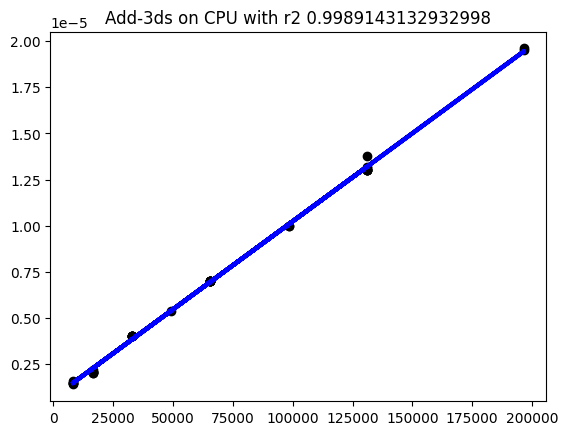

NNPA : original rows 132 , filtered rows 43
NNPA : regression coef,  [[1.94019635e-11 1.94019635e-11]] , intercept [1.93784857e-06] , r2,  0.9778124501464747


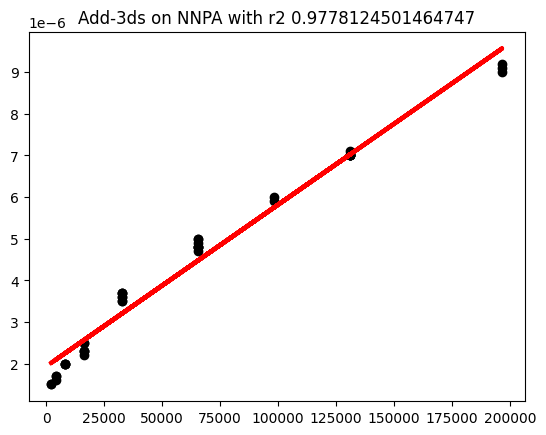

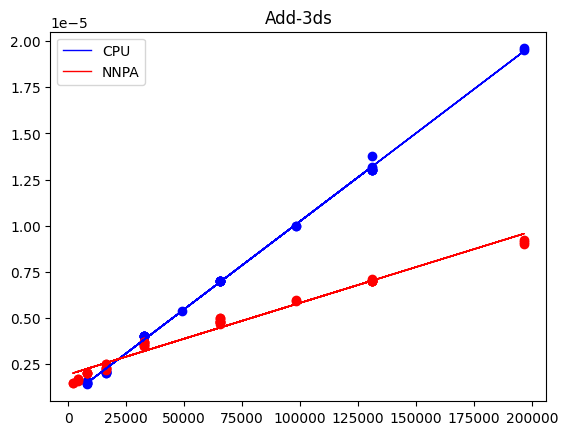

// Operation Add_3ds: estimated times.
static double z17_estimatedTimeForCPU_Add_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9989143132932998
  return 7.079949119005007e-07 + 9.532652779168236e-11 * complexity;
}
// Operation Add_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Add_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9778124501464747
  return 1.9378485722933562e-06 + 1.9401963539605186e-11 * complexity +1.9401963539605186e-11 * complexity2;
}



In [8]:
regdb["Add-3ds"] = compute_reg("Add-3ds", dir+"test_add_", max_compute=2e5, print_graph=2)

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_sub_2026-02-02-15-52-20.csv
CPU : original rows 132 , filtered rows 57
CPU : regression coef,  [[9.7087296e-11]] , intercept [5.92005523e-07] , r2,  0.9998869279375057


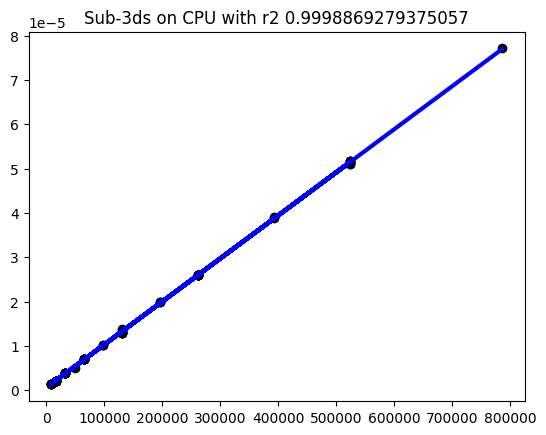

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.75572993e-11 1.75572993e-11]] , intercept [2.10434717e-06] , r2,  0.9962949578412905


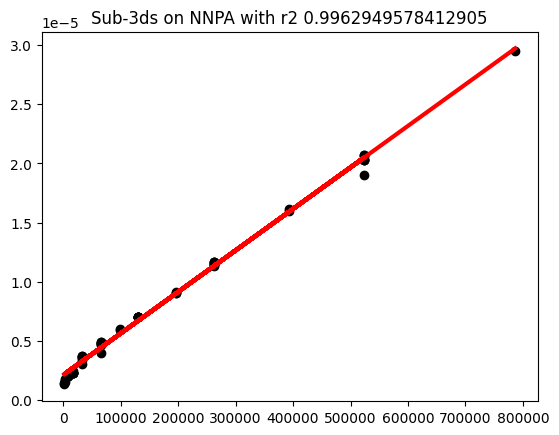

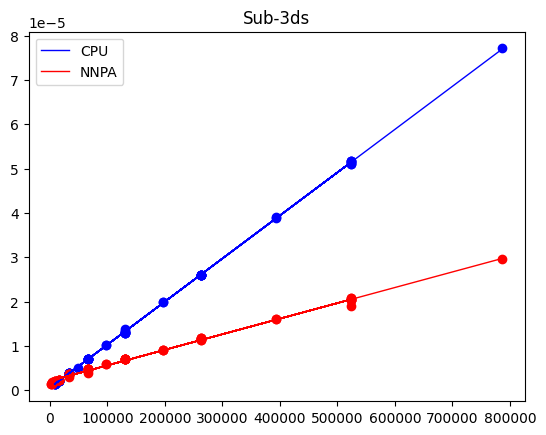

// Operation Sub_3ds: estimated times.
static double z17_estimatedTimeForCPU_Sub_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9998869279375057
  return 5.920055226928924e-07 + 9.708729601924833e-11 * complexity;
}
// Operation Sub_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Sub_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9962949578412905
  return 2.104347169742952e-06 + 1.7557299251689034e-11 * complexity +1.755729925168903e-11 * complexity2;
}



In [9]:
regdb["Sub-3ds"] = compute_reg("Sub-3ds", dir+"test_sub_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_div_2026-02-02-15-58-28.csv
CPU : original rows 132 , filtered rows 45
CPU : regression coef,  [[1.36116915e-09]] , intercept [6.16333277e-07] , r2,  0.9999948117308523


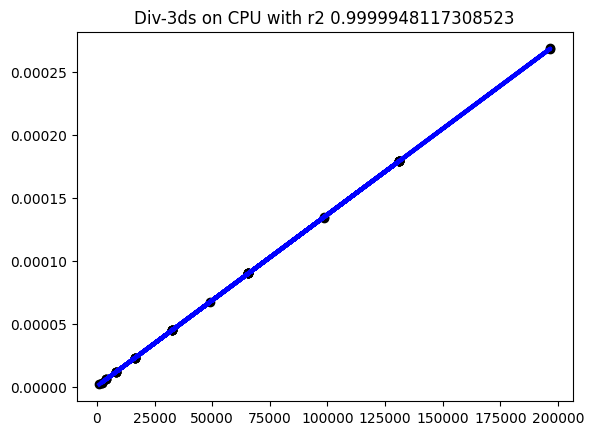

NNPA : original rows 132 , filtered rows 43
NNPA : regression coef,  [[2.81825826e-11 2.81825826e-11]] , intercept [2.51576031e-06] , r2,  0.984066407550124


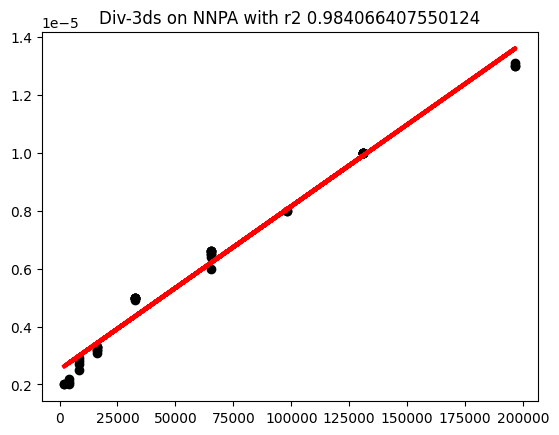

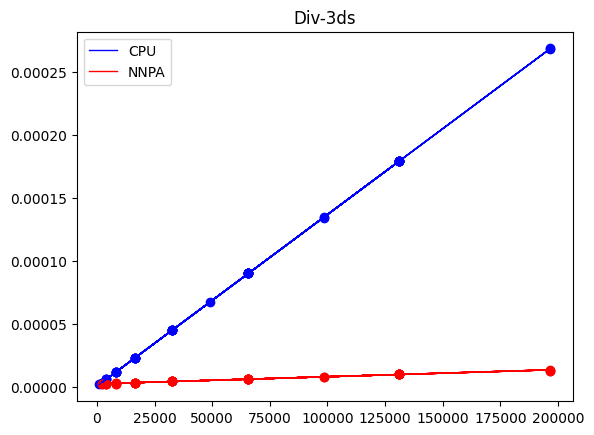

// Operation Div_3ds: estimated times.
static double z17_estimatedTimeForCPU_Div_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9999948117308523
  return 6.163332771021867e-07 + 1.3611691506833247e-09 * complexity;
}
// Operation Div_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Div_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.984066407550124
  return 2.515760309084214e-06 + 2.8182582596534027e-11 * complexity +2.8182582596534027e-11 * complexity2;
}



In [10]:
regdb["Div-3ds"] = compute_reg("Div-3ds", dir+"test_div_", max_compute=2e5, print_graph=2)

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_min_2026-02-02-16-05-24.csv
CPU : original rows 132 , filtered rows 57
CPU : regression coef,  [[9.52166357e-11]] , intercept [7.10565311e-07] , r2,  0.9998910700494343


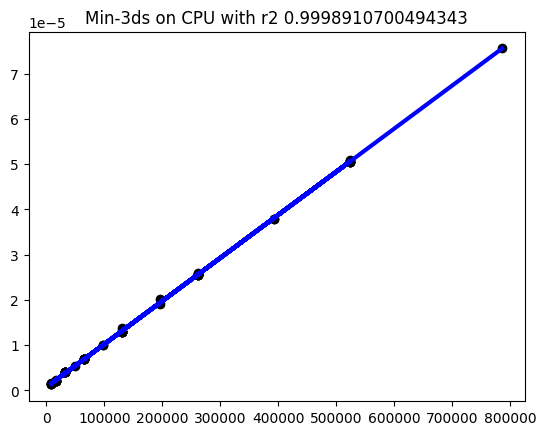

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.711011e-11 1.711011e-11]] , intercept [2.31048929e-06] , r2,  0.9951969030196546


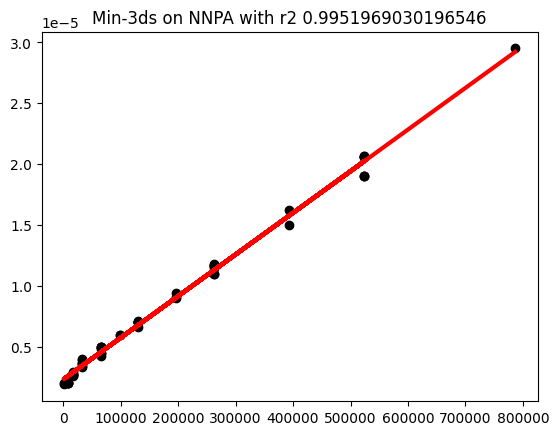

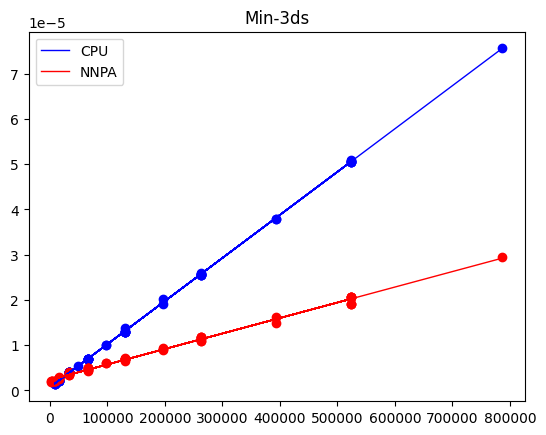

// Operation Min_3ds: estimated times.
static double z17_estimatedTimeForCPU_Min_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9998910700494343
  return 7.105653113228437e-07 + 9.521663571946669e-11 * complexity;
}
// Operation Min_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Min_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9951969030196546
  return 2.310489294932179e-06 + 1.711011004979247e-11 * complexity +1.7110110049792468e-11 * complexity2;
}



In [11]:
regdb["Min-3ds"] = compute_reg("Min-3ds", dir+"test_min_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_max_2026-02-02-16-02-13.csv
CPU : original rows 132 , filtered rows 57
CPU : regression coef,  [[9.53887104e-11]] , intercept [6.68336039e-07] , r2,  0.9998990192248702


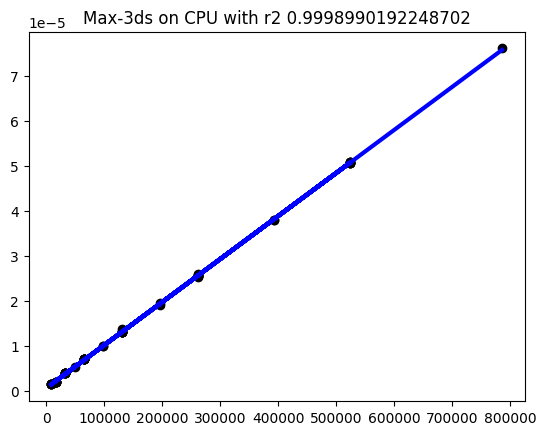

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.74917172e-11 1.74917172e-11]] , intercept [2.11870843e-06] , r2,  0.9967720056484983


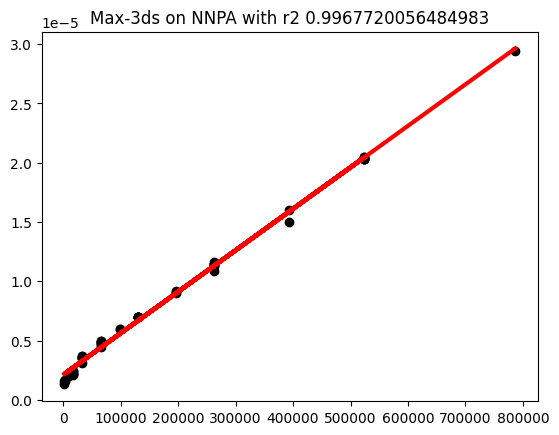

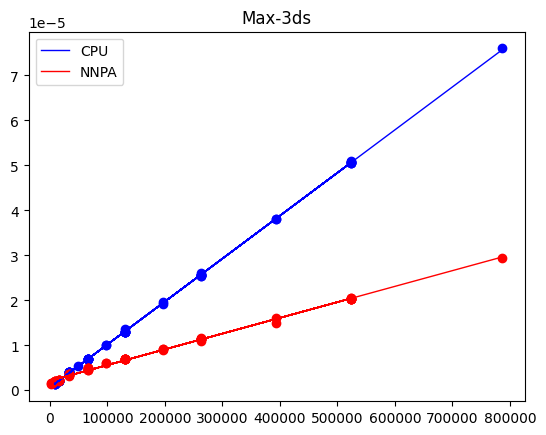

// Operation Max_3ds: estimated times.
static double z17_estimatedTimeForCPU_Max_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9998990192248702
  return 6.683360388828375e-07 + 9.538871035927159e-11 * complexity;
}
// Operation Max_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Max_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9967720056484983
  return 2.1187084327266474e-06 + 1.7491717197751822e-11 * complexity +1.749171719775182e-11 * complexity2;
}



In [12]:
regdb["Max-3ds"] = compute_reg("Max-3ds", dir+"test_max_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_mul_2026-02-02-15-55-26.csv
CPU : original rows 132 , filtered rows 57
CPU : regression coef,  [[9.68643289e-11]] , intercept [6.53618652e-07] , r2,  0.9998457939072593


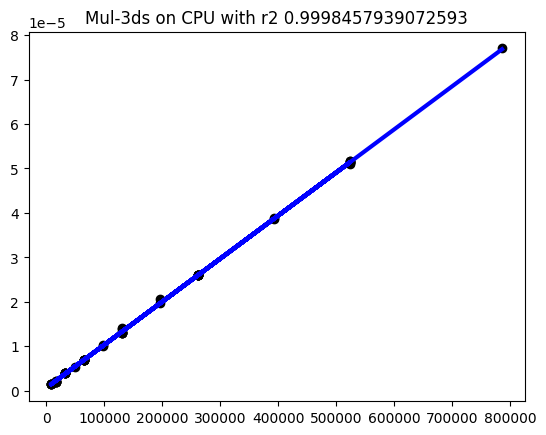

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.75370084e-11 1.75370084e-11]] , intercept [2.1016082e-06] , r2,  0.9966583749021439


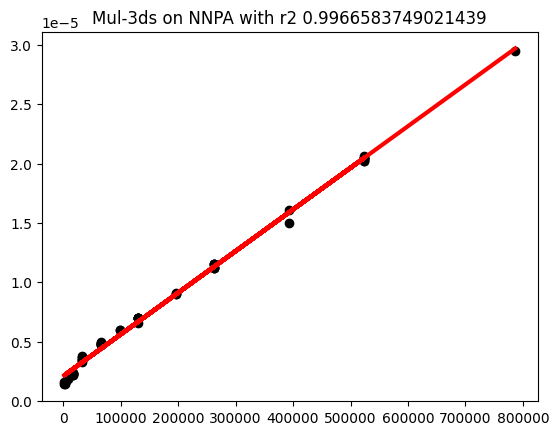

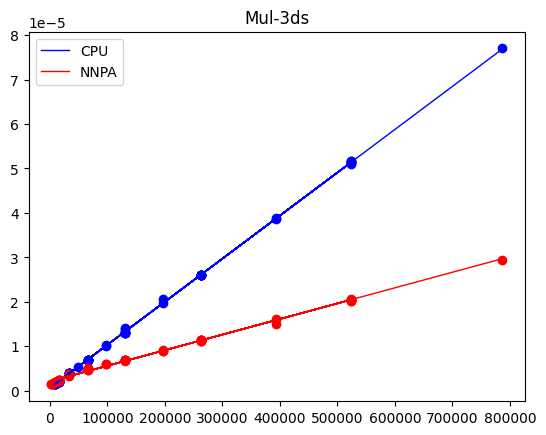

// Operation Mul_3ds: estimated times.
static double z17_estimatedTimeForCPU_Mul_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9998457939072593
  return 6.536186523954885e-07 + 9.686432885857678e-11 * complexity;
}
// Operation Mul_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Mul_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9966583749021439
  return 2.10160820170273e-06 + 1.7537008412023284e-11 * complexity +1.753700841202328e-11 * complexity2;
}



In [13]:
regdb["Mul-3ds"] = compute_reg("Mul-3ds", dir+"test_mul_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_pow-2_2026-02-02-17-22-27.csv
CPU : original rows 132 , filtered rows 56
CPU : regression coef,  [[9.74061715e-11]] , intercept [5.83551039e-07] , r2,  0.9998330708567645


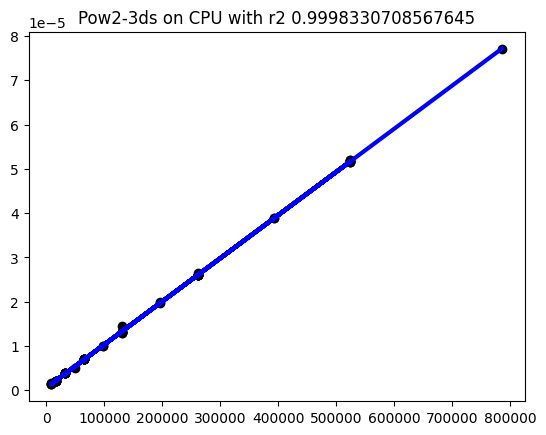

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.75439099e-11 1.75439099e-11]] , intercept [2.04602244e-06] , r2,  0.9957250692016835


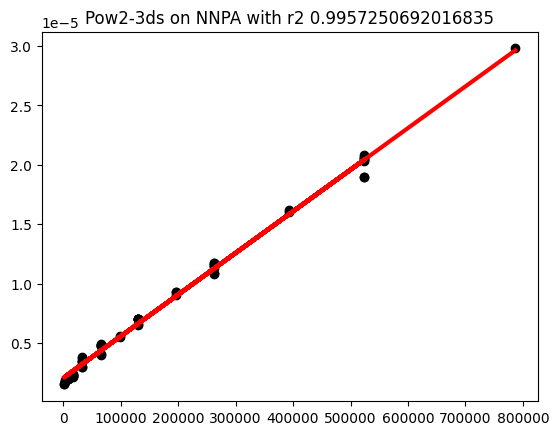

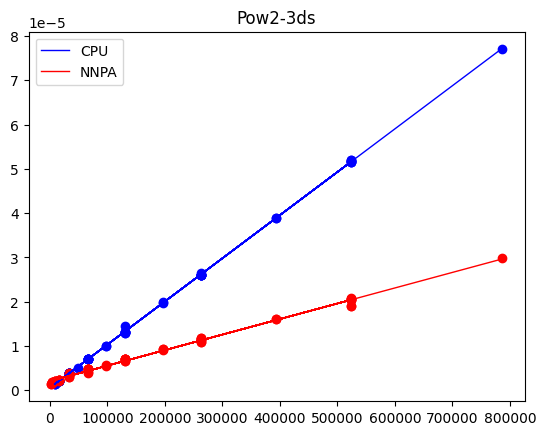

// Operation Pow2_3ds: estimated times.
static double z17_estimatedTimeForCPU_Pow2_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9998330708567645
  return 5.83551039493028e-07 + 9.740617149046747e-11 * complexity;
}
// Operation Pow2_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Pow2_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9957250692016835
  return 2.046022441224289e-06 + 1.754390987268152e-11 * complexity +1.7543909872681514e-11 * complexity2;
}



In [14]:
# pow2 is the same as mul in our experiments
regdb["Pow2-3ds"] = compute_reg("Pow2-3ds", dir+"test_pow-2_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_pow-3_2026-02-02-17-25-31.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[2.20343277e-10]] , intercept [1.48485938e-06] , r2,  0.9999259077587118


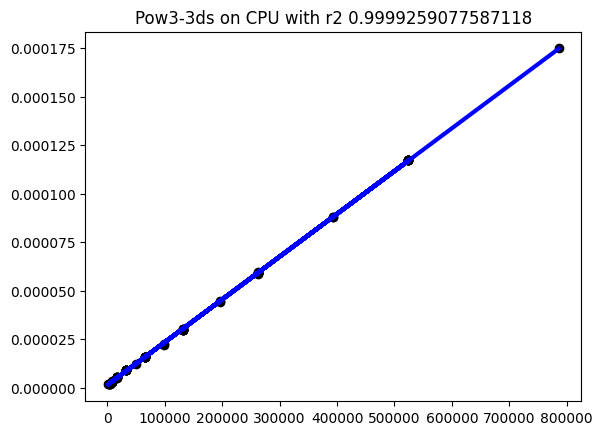

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[3.49149939e-11 3.49149939e-11]] , intercept [3.9656588e-06] , r2,  0.9981576537459496


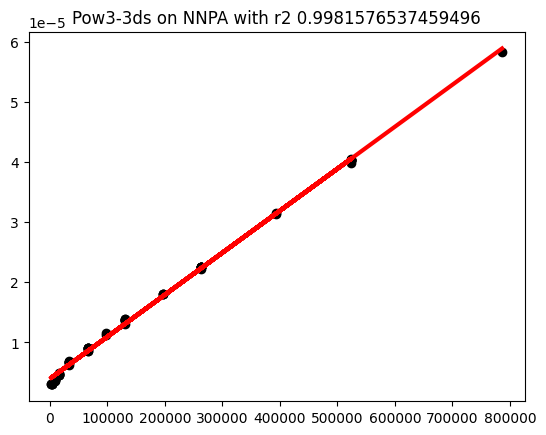

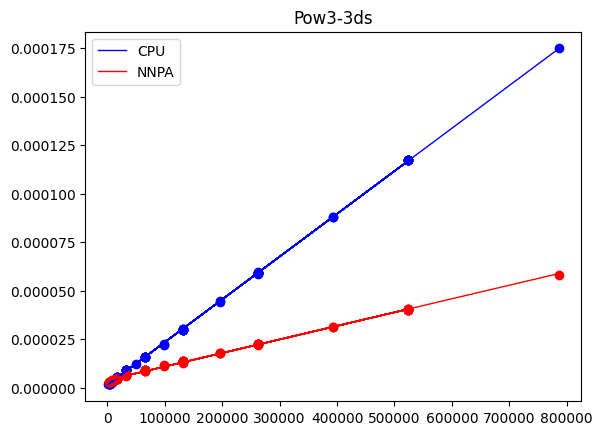

// Operation Pow3_3ds: estimated times.
static double z17_estimatedTimeForCPU_Pow3_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9999259077587118
  return 1.4848593765712085e-06 + 2.2034327699116254e-10 * complexity;
}
// Operation Pow3_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Pow3_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9981576537459496
  return 3.965658797888878e-06 + 3.491499390077144e-11 * complexity +3.491499390077143e-11 * complexity2;
}



In [15]:
regdb["Pow3-3ds"] = compute_reg("Pow3-3ds", dir+"test_pow-3_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_pow-4_2026-02-02-17-29-41.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[1.85504498e-10]] , intercept [1.26303395e-06] , r2,  0.99996382859299


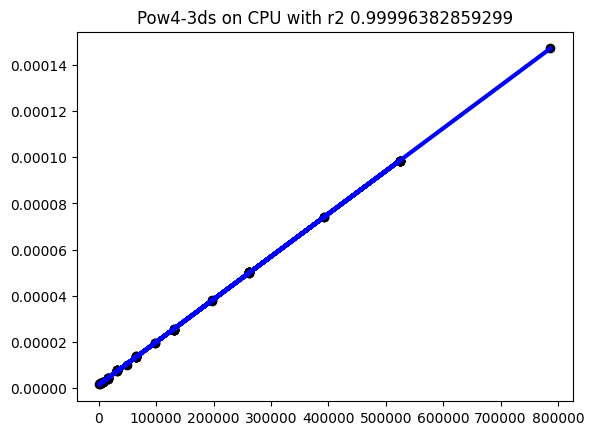

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[3.51924505e-11 3.51924505e-11]] , intercept [4.21916963e-06] , r2,  0.9968695629896515


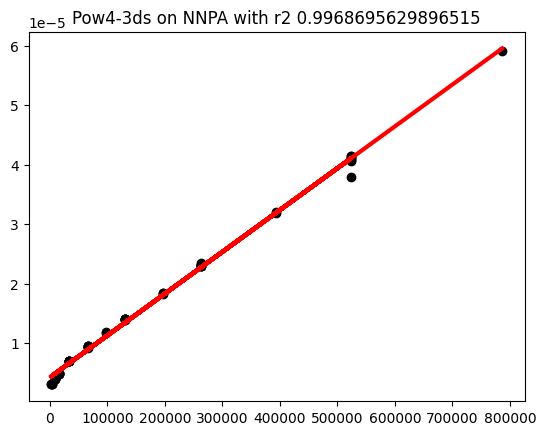

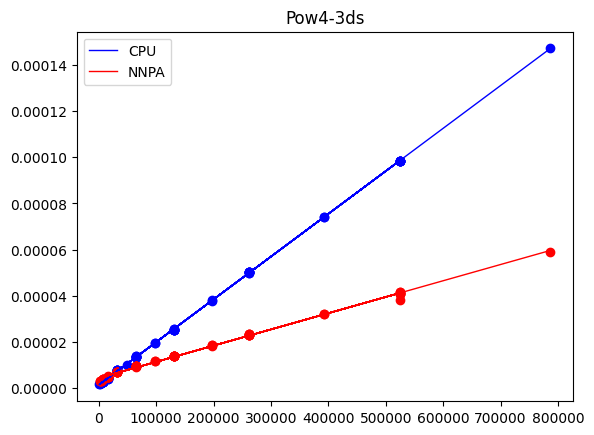

// Operation Pow4_3ds: estimated times.
static double z17_estimatedTimeForCPU_Pow4_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.99996382859299
  return 1.263033952025061e-06 + 1.8550449802598746e-10 * complexity;
}
// Operation Pow4_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Pow4_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9968695629896515
  return 4.219169630524296e-06 + 3.519245049395524e-11 * complexity +3.5192450493955235e-11 * complexity2;
}



In [16]:
regdb["Pow4-3ds"] = compute_reg("Pow4-3ds", dir+"test_pow-4_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_pow-8_2026-02-02-17-33-30.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[2.99081721e-10]] , intercept [2.25952037e-06] , r2,  0.9951503685878015


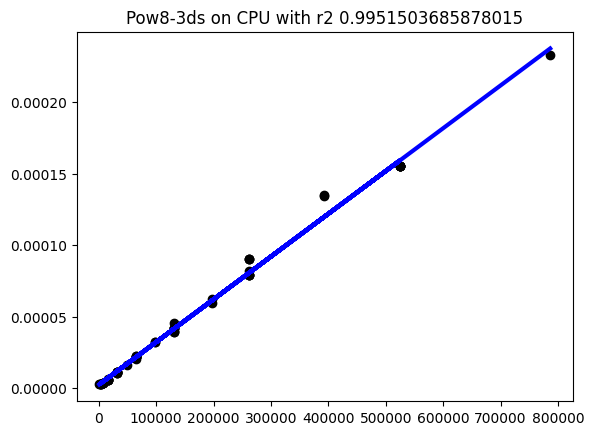

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[5.12234484e-11 5.12234484e-11]] , intercept [5.86156448e-06] , r2,  0.9951331030488707


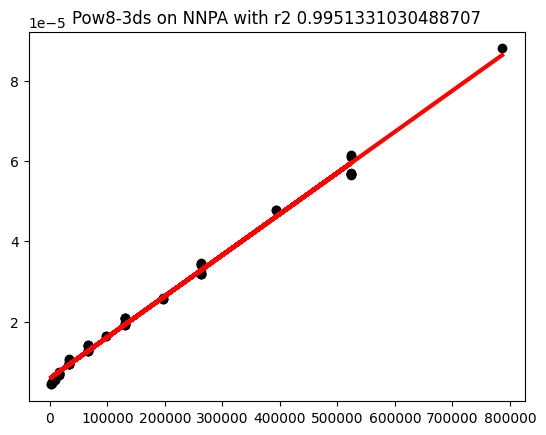

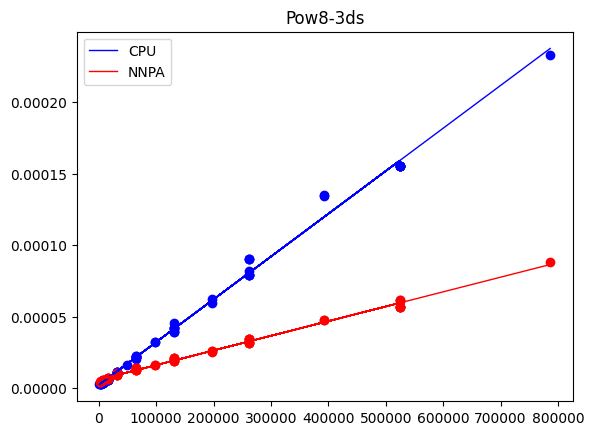

// Operation Pow8_3ds: estimated times.
static double z17_estimatedTimeForCPU_Pow8_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9951503685878015
  return 2.259520371701526e-06 + 2.990817209821375e-10 * complexity;
}
// Operation Pow8_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Pow8_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9951331030488707
  return 5.861564480019978e-06 + 5.12234483975942e-11 * complexity +5.12234483975942e-11 * complexity2;
}



In [17]:
regdb["Pow8-3ds"] = compute_reg("Pow8-3ds", dir+"test_pow-8_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_relu_2026-02-02-16-08-25.csv
CPU : original rows 132 , filtered rows 57
CPU : regression coef,  [[9.59384143e-11]] , intercept [6.00733509e-07] , r2,  0.9999000079614717


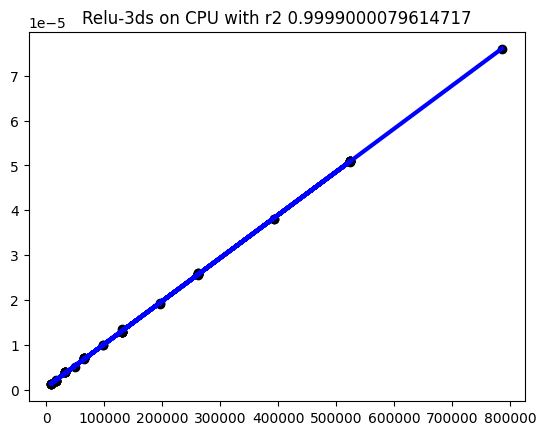

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[2.3265913e-11 2.3265913e-11]] , intercept [1.68938383e-06] , r2,  0.999457894943122


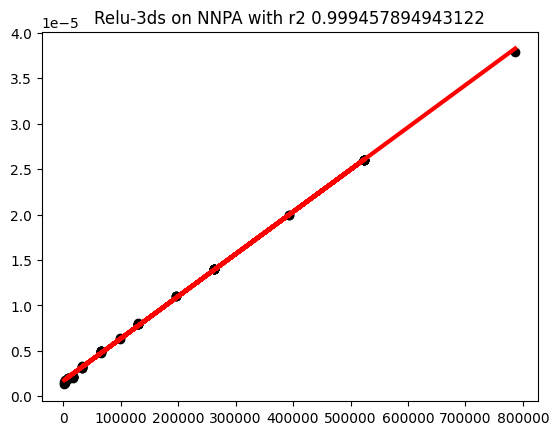

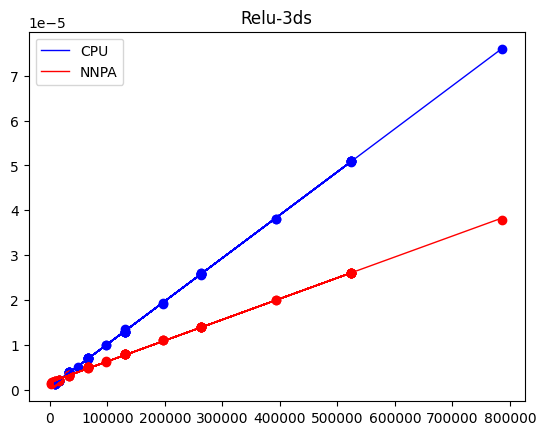

// Operation Relu_3ds: estimated times.
static double z17_estimatedTimeForCPU_Relu_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9999000079614717
  return 6.007335089933359e-07 + 9.5938414266056e-11 * complexity;
}
// Operation Relu_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Relu_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.999457894943122
  return 1.6893838323960414e-06 + 2.32659130251592e-11 * complexity +2.3265913025159193e-11 * complexity2;
}



In [18]:
regdb["Relu-3ds"] = compute_reg("Relu-3ds", dir+"test_relu_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_gelu_2026-02-02-16-18-14.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[3.43731446e-08]] , intercept [3.88863298e-05] , r2,  0.9985359656343379


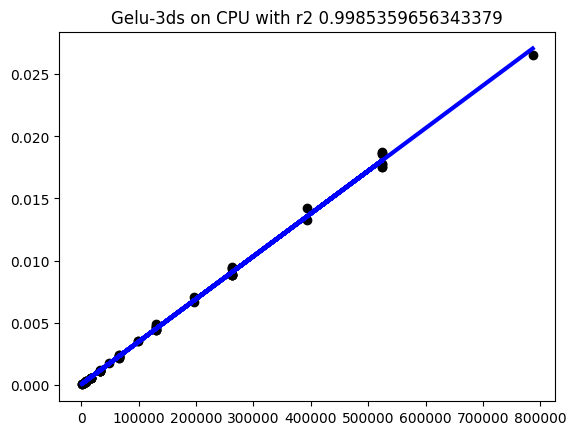

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[3.49691437e-11 3.49691437e-11]] , intercept [1.7100455e-06] , r2,  0.9998532611720768


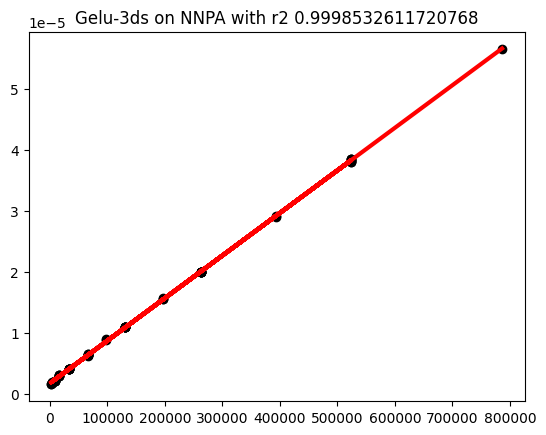

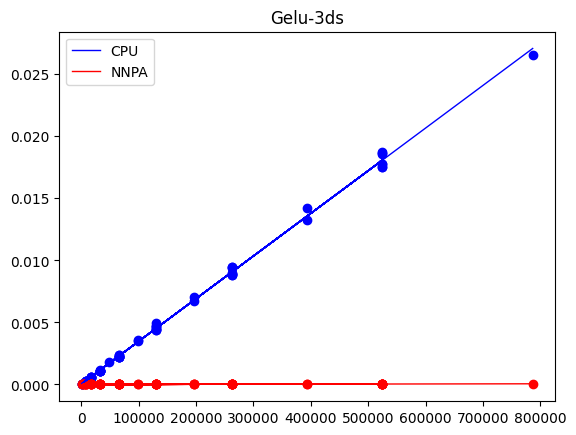

// Operation Gelu_3ds: estimated times.
static double z17_estimatedTimeForCPU_Gelu_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9985359656343379
  return 3.8886329789052966e-05 + 3.4373144604030794e-08 * complexity;
}
// Operation Gelu_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Gelu_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9998532611720768
  return 1.7100455011762154e-06 + 3.496914370633557e-11 * complexity +3.496914370633556e-11 * complexity2;
}



In [19]:
regdb["Gelu-3ds"] = compute_reg("Gelu-3ds", dir+"test_gelu_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_sigmoid_2026-02-02-16-58-42.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[4.87720464e-09]] , intercept [1.34651524e-06] , r2,  0.9999625496058935


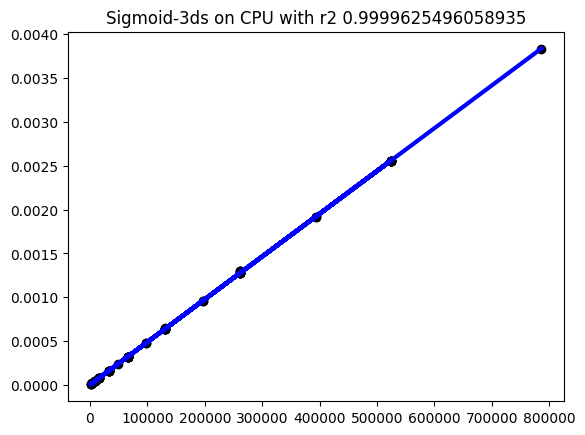

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[3.7381698e-11 3.7381698e-11]] , intercept [2.25926625e-06] , r2,  0.999773150055181


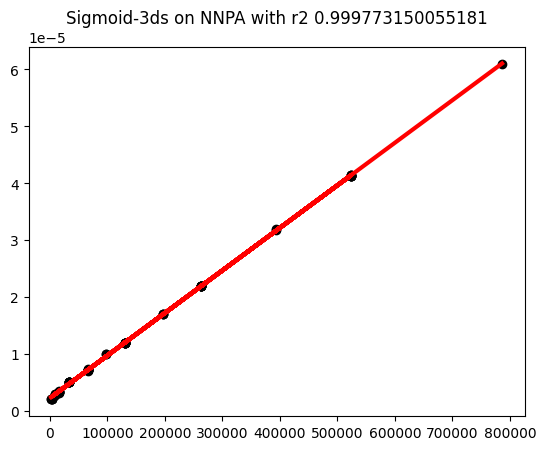

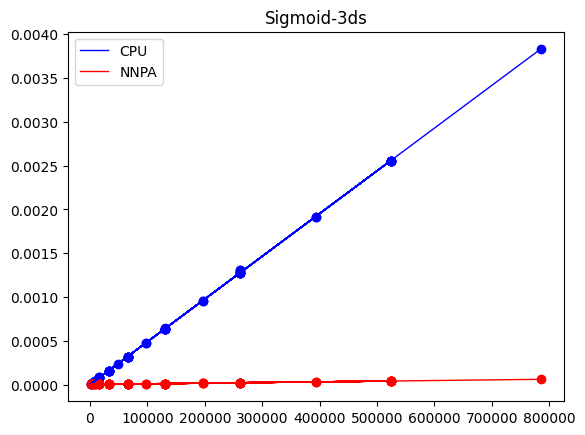

// Operation Sigmoid_3ds: estimated times.
static double z17_estimatedTimeForCPU_Sigmoid_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9999625496058935
  return 1.3465152438538186e-06 + 4.877204640371145e-09 * complexity;
}
// Operation Sigmoid_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Sigmoid_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.999773150055181
  return 2.2592662530481885e-06 + 3.738169803347048e-11 * complexity +3.7381698033470476e-11 * complexity2;
}



In [20]:
regdb["Sigmoid-3ds"] = compute_reg("Sigmoid-3ds", dir+"test_sigmoid_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_tanh_2026-02-02-16-39-25.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[3.00179358e-08]] , intercept [-8.53641929e-05] , r2,  0.9872828791540809


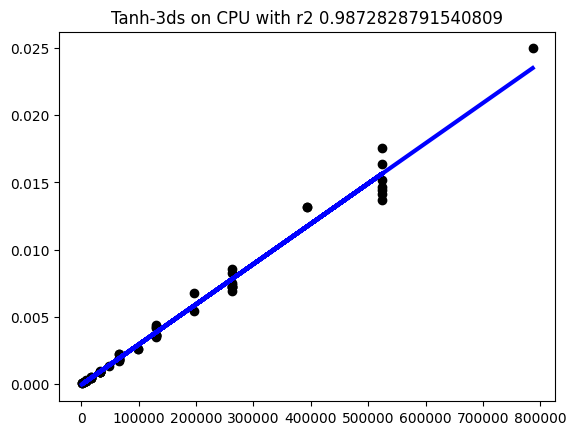

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.70156118e-11 1.70156118e-11]] , intercept [1.75731908e-06] , r2,  0.9981978992772614


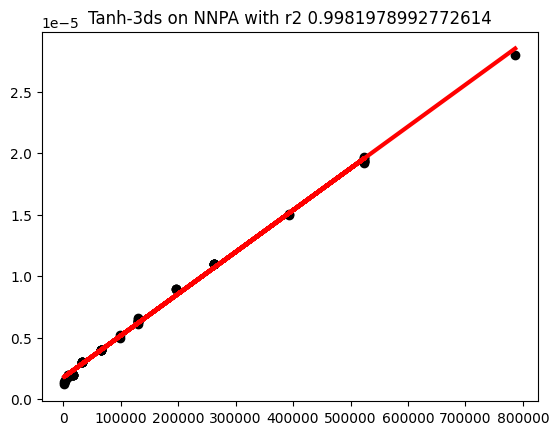

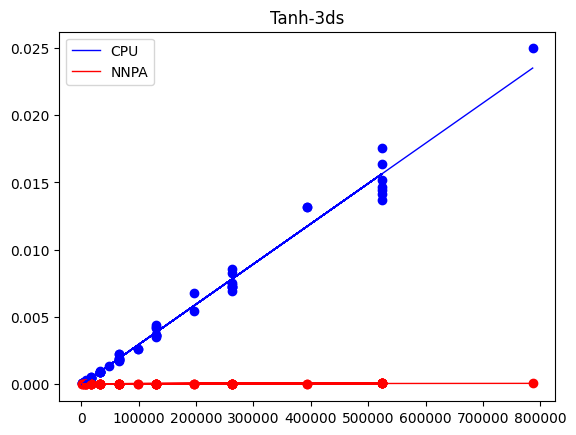

// Operation Tanh_3ds: estimated times.
static double z17_estimatedTimeForCPU_Tanh_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9872828791540809
  return -8.536419285777239e-05 + 3.001793576020331e-08 * complexity;
}
// Operation Tanh_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Tanh_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9981978992772614
  return 1.7573190789371632e-06 + 1.7015611845173706e-11 * complexity +1.7015611845173703e-11 * complexity2;
}



In [21]:
regdb["Tanh-3ds"] = compute_reg("Tanh-3ds", dir+"test_tanh_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_log_2026-02-02-17-16-33.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[4.62108727e-09]] , intercept [1.06572121e-05] , r2,  0.9882511675464245


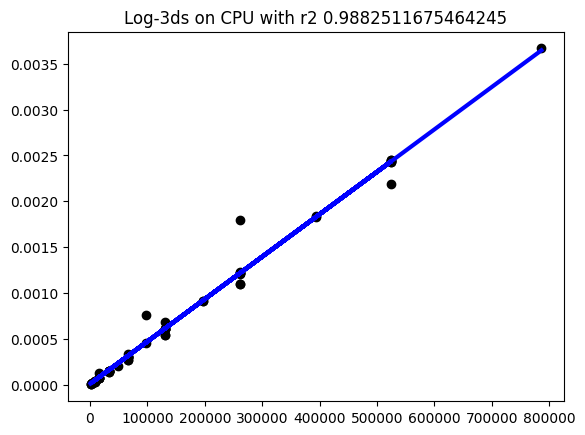

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[3.04915136e-11 3.04915136e-11]] , intercept [2.20407405e-06] , r2,  0.9997360153499352


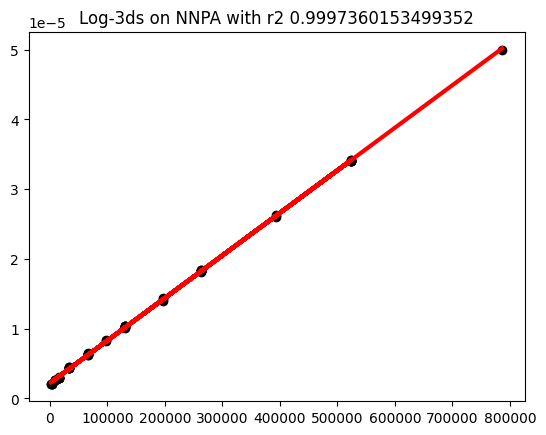

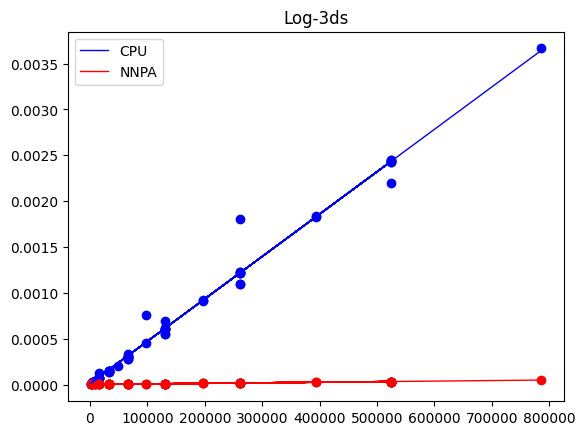

// Operation Log_3ds: estimated times.
static double z17_estimatedTimeForCPU_Log_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9882511675464245
  return 1.0657212112899148e-05 + 4.621087273482515e-09 * complexity;
}
// Operation Log_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Log_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9997360153499352
  return 2.204074053483836e-06 + 3.049151359848199e-11 * complexity +3.0491513598481985e-11 * complexity2;
}



In [22]:
regdb["Log-3ds"] = compute_reg("Log-3ds", dir+"test_log_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_exp_2026-02-02-17-11-19.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[3.63339715e-09]] , intercept [6.17285448e-06] , r2,  0.9962940292636632


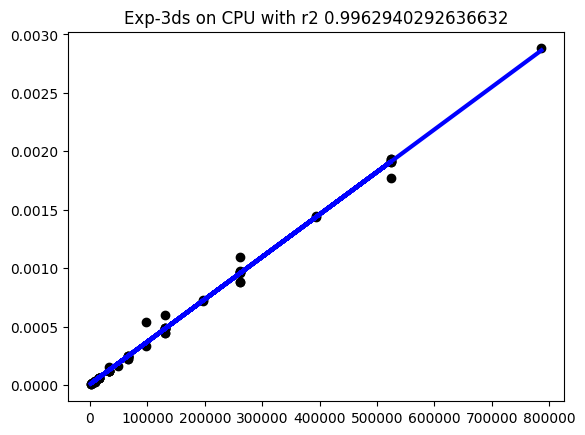

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[2.56393899e-11 2.56393899e-11]] , intercept [2.08583809e-06] , r2,  0.9995097696721361


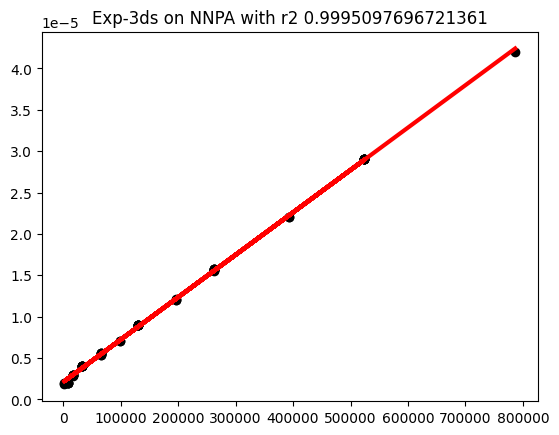

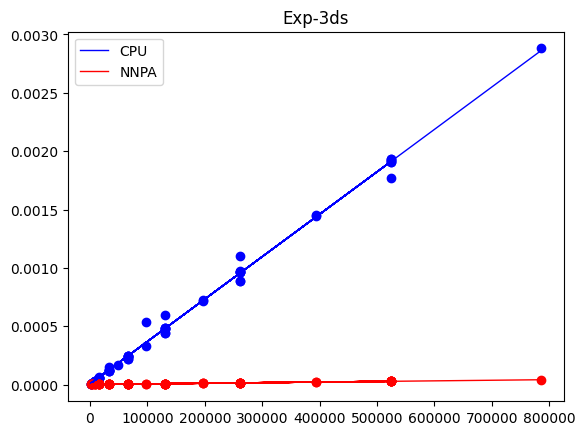

// Operation Exp_3ds: estimated times.
static double z17_estimatedTimeForCPU_Exp_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9962940292636632
  return 6.172854482160411e-06 + 3.633397146246287e-09 * complexity;
}
// Operation Exp_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Exp_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9995097696721361
  return 2.0858380924028634e-06 + 2.5639389876306285e-11 * complexity +2.563938987630628e-11 * complexity2;
}



In [23]:
regdb["Exp-3ds"] = compute_reg("Exp-3ds", dir+"test_exp_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_softmax_2026-02-02-17-04-20.csv
CPU : original rows 132 , filtered rows 45
CPU : regression coef,  [[5.84236383e-09]] , intercept [4.75402451e-07] , r2,  0.9793864717872062


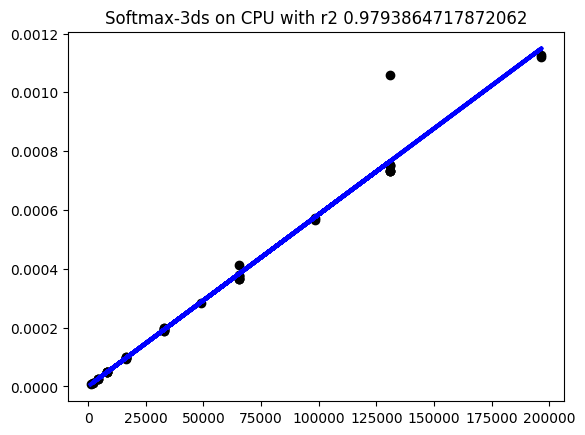

NNPA : original rows 132 , filtered rows 43
NNPA : regression coef,  [[4.68242233e-10 4.68242233e-10]] , intercept [-1.8468302e-07] , r2,  0.28899728682085823


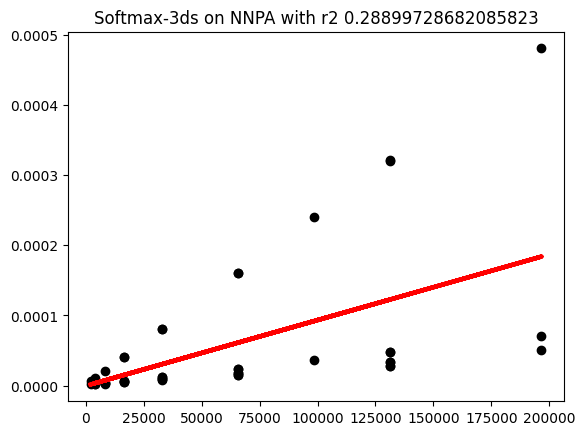

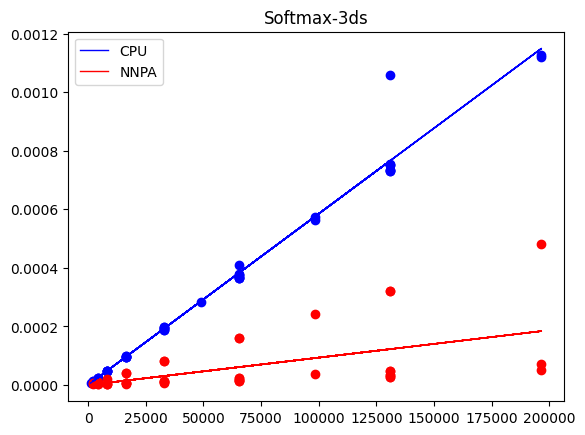

// Operation Softmax_3ds: estimated times.
static double z17_estimatedTimeForCPU_Softmax_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9793864717872062
  return 4.754024513415646e-07 + 5.842363831577662e-09 * complexity;
}
// Operation Softmax_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Softmax_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.28899728682085823
  return -1.8468302022715214e-07 + 4.682422331611985e-10 * complexity +4.682422331611985e-10 * complexity2;
}



In [24]:
regdb["Softmax-3ds"] = compute_reg("Softmax-3ds", dir+"test_softmax_", max_compute=2e5, print_graph=2)

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_reducemean_2026-02-02-17-38-26.csv
CPU : original rows 132 , filtered rows 56
CPU : regression coef,  [[1.27921122e-10]] , intercept [-1.47270863e-07] , r2,  0.9580395776892906


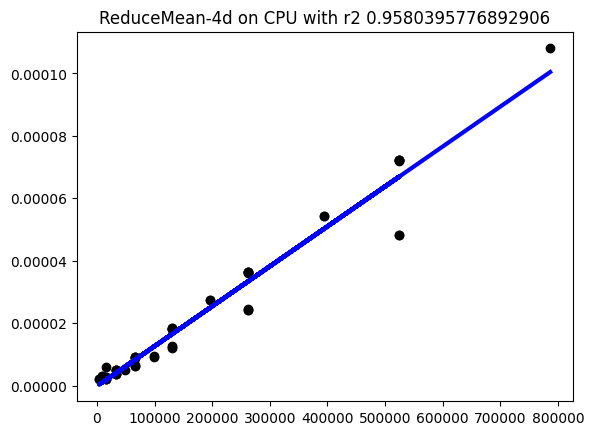

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[9.76009535e-12 9.76009535e-12]] , intercept [1.1146407e-05] , r2,  0.24156307188728987


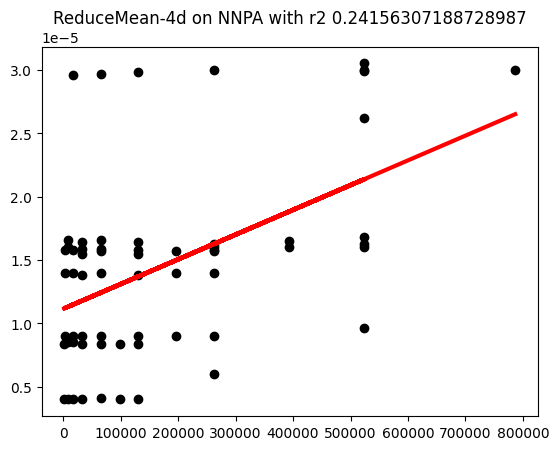

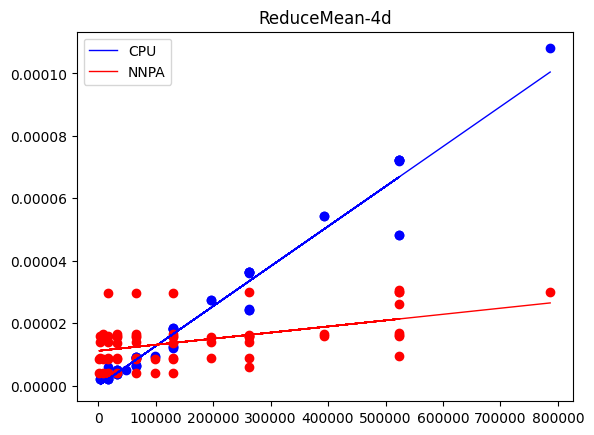

// Operation ReduceMean_4d: estimated times.
static double z17_estimatedTimeForCPU_ReduceMean_4d_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9580395776892906
  return -1.472708629415125e-07 + 1.279211222153757e-10 * complexity;
}
// Operation ReduceMean_4d: estimated times.
static double z17_estimatedTimeForNNPA_ReduceMean_4d(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.24156307188728987
  return 1.1146406992987382e-05 + 9.760095348554244e-12 * complexity +9.760095348554242e-12 * complexity2;
}



In [25]:
regdb["ReduceMean-4d"] = compute_reg("ReduceMean-4d", dir+"test_reducemean_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_stick_2026-02-02-18-04-04.csv
CPU : original rows 132 , filtered rows 35
CPU : regression coef,  [[8.29953912e-11]] , intercept [6.70047026e-07] , r2,  0.9812096111947632


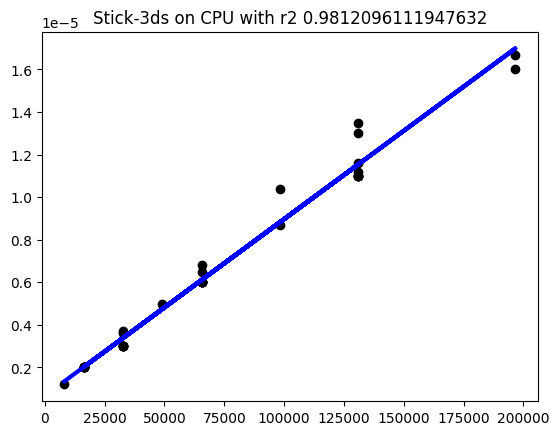

NNPA : original rows 132 , filtered rows 43
NNPA : regression coef,  [[1.59675081e-10 1.59675081e-10]] , intercept [1.33062971e-06] , r2,  0.7146697047188758


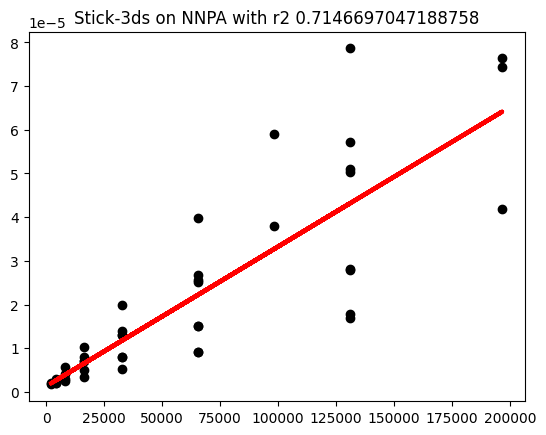

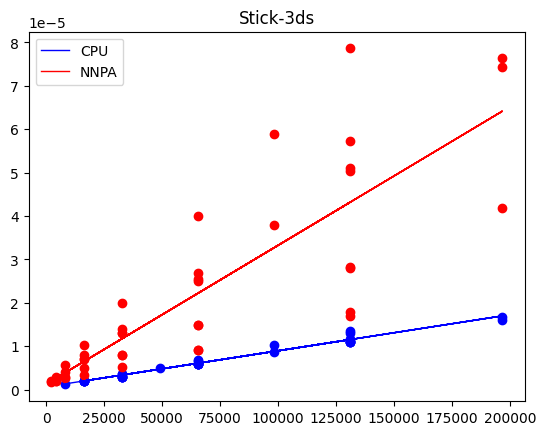

// Operation Stick_3ds: estimated times.
static double z17_estimatedTimeForCPU_Stick_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9812096111947632
  return 6.700470263915355e-07 + 8.299539118875926e-11 * complexity;
}
// Operation Stick_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Stick_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.7146697047188758
  return 1.330629713883447e-06 + 1.5967508141121535e-10 * complexity +1.5967508141121535e-10 * complexity2;
}



In [26]:
regdb["Stick-3ds"] = compute_reg("Stick-3ds", dir+"test_stick_", max_compute=2e5)

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_stick_2026-02-02-18-04-04.csv
CPU : original rows 132 , filtered rows 53
CPU : regression coef,  [[8.29415246e-11]] , intercept [7.31989393e-07] , r2,  0.9943465538210656


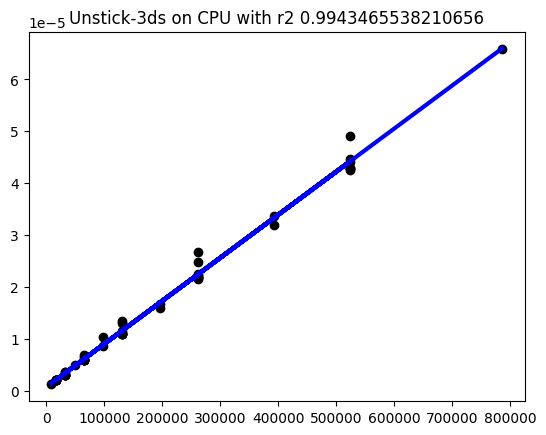

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.23263988e-10 1.23263988e-10]] , intercept [7.09343565e-06] , r2,  0.6000170750511324


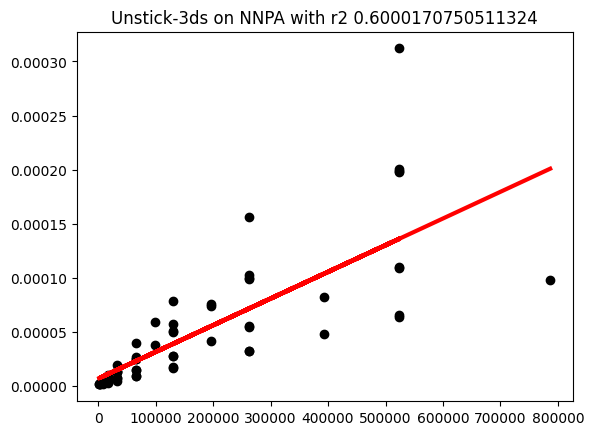

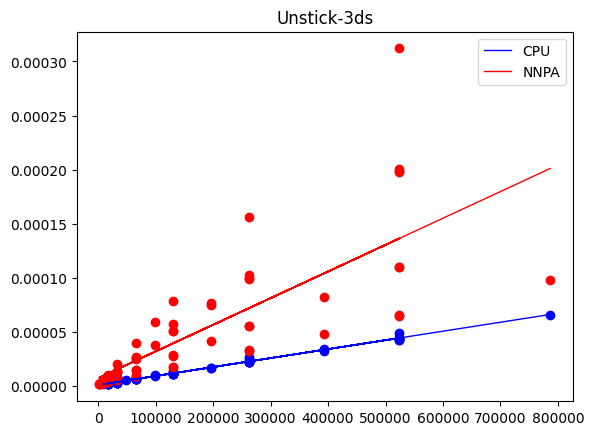

// Operation Unstick_3ds: estimated times.
static double z17_estimatedTimeForCPU_Unstick_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9943465538210656
  return 7.319893933211372e-07 + 8.294152459387901e-11 * complexity;
}
// Operation Unstick_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Unstick_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.6000170750511324
  return 7.093435648416282e-06 + 1.2326398798419612e-10 * complexity +1.232639879841961e-10 * complexity2;
}



In [27]:
regdb["Unstick-3ds"] = compute_reg("Unstick-3ds", dir+"test_stick_")
#plot_regressions(regdb, (("Stick-3ds","nnpa"),("Unstick-3ds","nnpa")))


used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_matmul_3d_2026-02-02-18-01-52.csv
CPU: Use MatMul 3D compute complexity.
CPU : original rows 90 , filtered rows 45
CPU : regression coef,  [[4.9536694e-11]] , intercept [4.04909422e-07] , r2,  0.9990076510881734


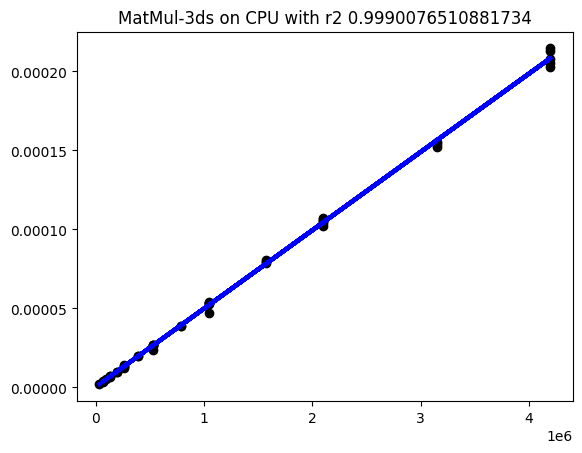

NNPA: Use MatMul 3D compute complexity.
NNPA : original rows 90 , filtered rows 40
NNPA : regression coef,  [[8.58674744e-13 8.58674744e-13]] , intercept [2.00384282e-06] , r2,  0.6998309749726329


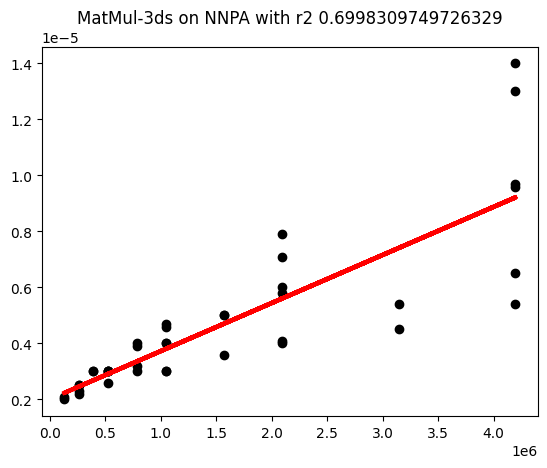

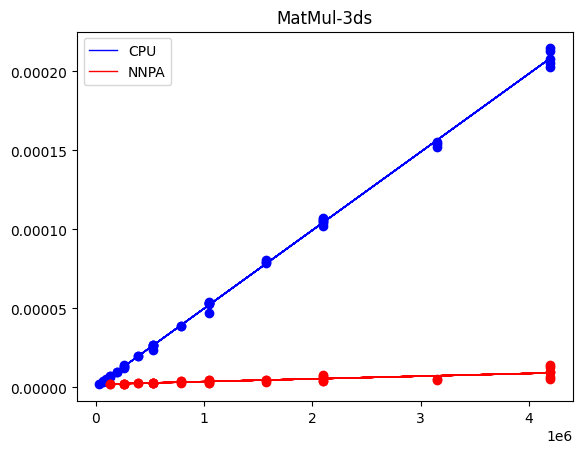

// Operation MatMul_3ds: estimated times.
static double z17_estimatedTimeForCPU_MatMul_3ds_(double B, double N, double M, double K) {
  double complexity = B * (N * M * K);
  // Regression for CPU with r2 = 0.9990076510881734
  return 4.0490942153444847e-07 + 4.953669398280704e-11 * complexity;
}
// Operation MatMul_3ds: estimated times.
static double z17_estimatedTimeForNNPA_MatMul_3ds(double B, double N, double M, double K) {
  double complexity  = B * ms_ceiling(N, 2.0) * ms_ceiling(M, 64.0) * ms_ceiling(K, 64.0);
  double complexity2 = B * ms_ceiling(N, 32.0) * ms_ceiling(M, 64.0) * ms_ceiling(K, 64.0);
  // Regression for NNPA with r2 = 0.6998309749726329
  return 2.003842815814851e-06 + 8.58674743711201e-13 * complexity +8.58674743711201e-13 * complexity2;
}



In [28]:
regdb["MatMul-3ds"] = compute_reg("MatMul-3ds", dir+"test_matmul_3d_", max_compute=5e6, min_e2=32, min_e1=32)

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_matmul_bcast23_2026-02-02-18-02-59.csv
CPU: Use MatMul 3D compute complexity.
CPU : original rows 90 , filtered rows 45
CPU : regression coef,  [[5.12651681e-11]] , intercept [4.45477704e-07] , r2,  0.9939326252886348


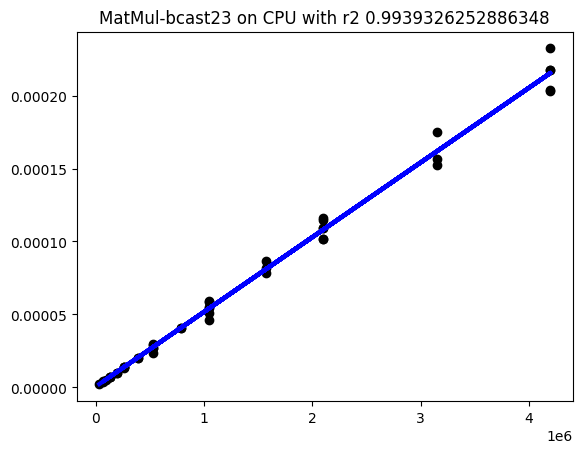

NNPA: Use MatMul 3D compute complexity.
NNPA : original rows 90 , filtered rows 40
NNPA : regression coef,  [[5.65767058e-13 5.65767058e-13]] , intercept [2.12775072e-06] , r2,  0.8472812638567532


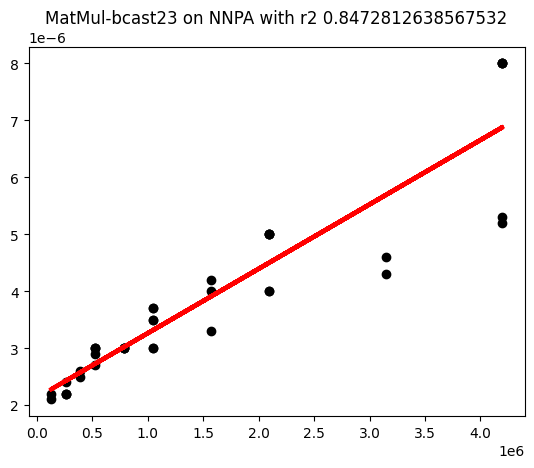

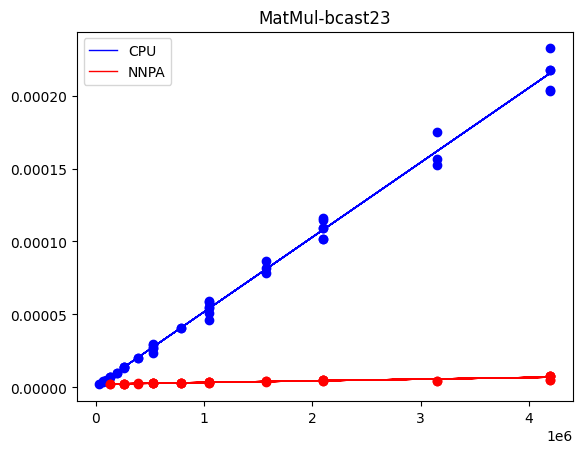

// Operation MatMul_bcast23: estimated times.
static double z17_estimatedTimeForCPU_MatMul_bcast23_(double B, double N, double M, double K) {
  double complexity = B * (N * M * K);
  // Regression for CPU with r2 = 0.9939326252886348
  return 4.454777035986697e-07 + 5.1265168142327886e-11 * complexity;
}
// Operation MatMul_bcast23: estimated times.
static double z17_estimatedTimeForNNPA_MatMul_bcast23(double B, double N, double M, double K) {
  double complexity  = B * ms_ceiling(N, 2.0) * ms_ceiling(M, 64.0) * ms_ceiling(K, 64.0);
  double complexity2 = B * ms_ceiling(N, 32.0) * ms_ceiling(M, 64.0) * ms_ceiling(K, 64.0);
  // Regression for NNPA with r2 = 0.8472812638567532
  return 2.1277507232401163e-06 + 5.657670582961668e-13 * complexity +5.657670582961668e-13 * complexity2;
}



In [29]:
regdb["MatMul-bcast23"] = compute_reg("MatMul-bcast23", dir+"test_matmul_bcast23_", max_compute=5e6, min_e2=32, min_e1=32)

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_leakyrelu_2026-02-02-16-15-16.csv
CPU : original rows 132 , filtered rows 57
CPU : regression coef,  [[1.08179536e-10]] , intercept [1.42168759e-07] , r2,  0.9927591502177014


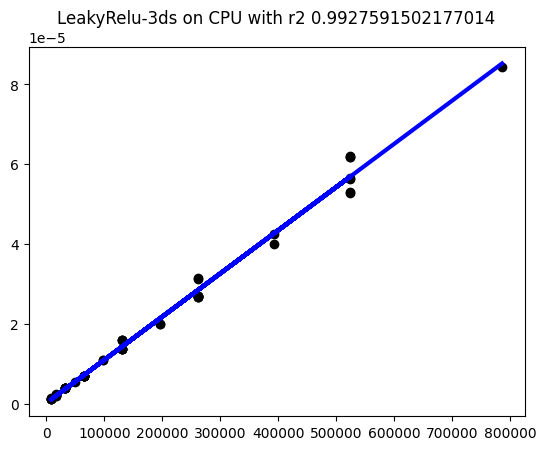

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[2.32569878e-11 2.32569878e-11]] , intercept [1.63598421e-06] , r2,  0.9992097376478082


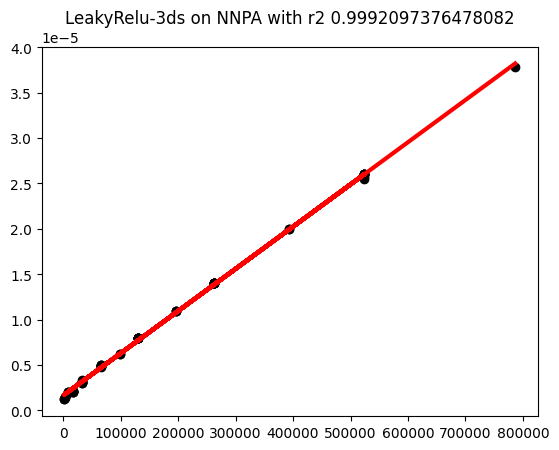

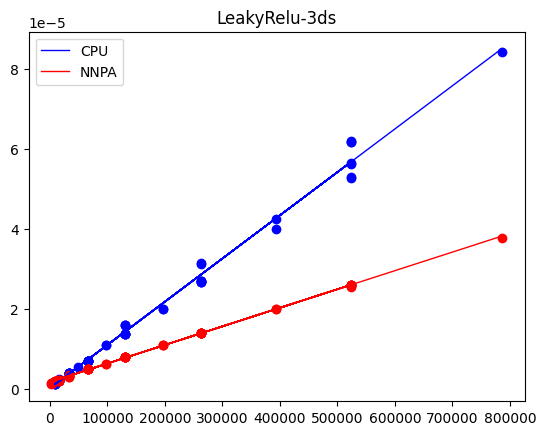

// Operation LeakyRelu_3ds: estimated times.
static double z17_estimatedTimeForCPU_LeakyRelu_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9927591502177014
  return 1.421687588512398e-07 + 1.0817953556686182e-10 * complexity;
}
// Operation LeakyRelu_3ds: estimated times.
static double z17_estimatedTimeForNNPA_LeakyRelu_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9992097376478082
  return 1.63598420569257e-06 + 2.3256987782358853e-11 * complexity +2.3256987782358853e-11 * complexity2;
}



In [30]:
regdb["LeakyRelu-3ds"] = compute_reg("LeakyRelu-3ds", dir+"test_leakyrelu_")

used name as prefix to load this input file /Users/alexe/OM/onnx-mlir/utils/NNPAOpPerfModel/res/test_sqrt_2026-02-02-16-11-27.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[1.70251505e-09]] , intercept [5.10184557e-07] , r2,  0.9999997444067408


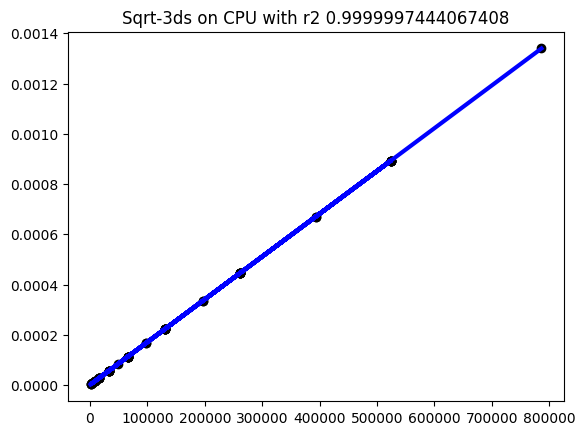

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[5.89043878e-11 5.89043878e-11]] , intercept [2.17216451e-06] , r2,  0.9998815342680107


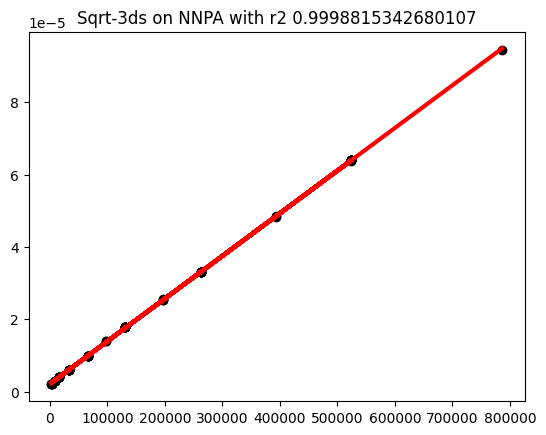

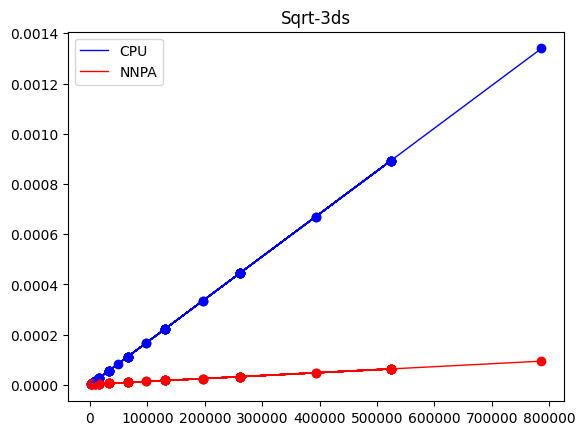

// Operation Sqrt_3ds: estimated times.
static double z17_estimatedTimeForCPU_Sqrt_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9999997444067408
  return 5.101845573917828e-07 + 1.7025150507233224e-09 * complexity;
}
// Operation Sqrt_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Sqrt_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9998815342680107
  return 2.172164509330741e-06 + 5.890438783443371e-11 * complexity +5.890438783443371e-11 * complexity2;
}



In [31]:
regdb["Sqrt-3ds"] = compute_reg("Sqrt-3ds", dir+"test_sqrt_")

### print("""
/*
 * SPDX-License-Identifier: Apache-2.0
 */

//===----------------- Auto-Generated, do not change  ---------------------===//
//
// Copyright 2025 The IBM Research Authors.
// Generated by the utils/NNPAOpPerfModel/generateModel.ipynb
// See Readme in that directory for more info.
//
// =============================================================================

inline static double ms_ceiling(double n, double m) { return ceil(n / m) * m; }

""")
      
for op in sorted(regdb):
    print(regdb[op]["code"])